# Data Ingestion 
This notebook details the initial development of the data ingestion scripts

## Packages

In [67]:
import os 
from google.transit import gtfs_realtime_pb2
import requests
from time import sleep
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Functions

In [ ]:
def fetch_gtfs_data(url: str) -> bytes | None:
    """
    Fetch GTFS real-time data from the given URL.
    """
    response = requests.get(url)
    if response.status_code == 200:
        return response.content
    else:
        return None

def parse_gtfs_data(data: bytes) -> gtfs_realtime_pb2.FeedMessage | None:
    """
    Parse GTFS real-time data from bytes.
    """
    feed = gtfs_realtime_pb2.FeedMessage()
    feed.ParseFromString(data)
    return feed

def feed_entity_to_dict(entity: gtfs_realtime_pb2.FeedEntity) -> dict:
    """
    Convert a FeedEntity to a dictionary, handling missing fields gracefully.

    Parameters:
    -----------
    entity: gtfs_realtime_pb2.FeedEntity
        The FeedEntity to convert.

    Returns
    -------
    dict
        A dictionary representation of the FeedEntity.
    """
    vehicle = entity.vehicle if entity.HasField("vehicle") else None

    def get_field(obj, field):
        return getattr(obj, field) if obj and obj.HasField(field) else None

    trip = vehicle.trip if vehicle and vehicle.HasField("trip") else None
    position = vehicle.position if vehicle and vehicle.HasField("position") else None
    vehicle_info = vehicle.vehicle if vehicle and vehicle.HasField("vehicle") else None

    return {
        "entity_id": getattr(entity, "id", None),
        "trip_id": get_field(trip, "trip_id"),
        "trip_start_time": get_field(trip, "start_time"),
        "trip_start_date": get_field(trip, "start_date"),
        "trip_schedule_relationship": get_field(trip, "schedule_relationship"),
        "trip_route_id": get_field(trip, "route_id"),
        "trip_direction_id": get_field(trip, "direction_id"),
        "position_latitude": get_field(position, "latitude"),
        "position_longitude": get_field(position, "longitude"),
        "position_bearing": get_field(position, "bearing"),
        "position_odometer": get_field(position, "odometer"),
        "position_speed": get_field(position, "speed"),
        "current_stop_sequence": get_field(vehicle, "current_stop_sequence"),
        "current_status": get_field(vehicle, "current_status"),
        "timestamp": get_field(vehicle, "timestamp"),
        "congestion_level": get_field(vehicle, "congestion_level"),
        "stop_id": get_field(vehicle, "stop_id"),
        "vehicle_id": get_field(vehicle_info, "id"),
        "vehicle_label": get_field(vehicle_info, "label"),
    }

## Constants

In [ ]:
realtime_vehicle_updates_url = "https://bct.tmix.se/gtfs-realtime/vehicleupdates.pb?operatorIds=47"

root_dir = os.path.dirname(os.path.abspath("."))  # Fixed typo from dirname to dir
data_dir = os.path.join(root_dir, "data")
src_dir = os.path.join(root_dir, "src")
os.makedirs(data_dir, exist_ok=True)

df_path = os.path.join(data_dir, "vehicle_updates.csv")


# script parameter 
download = False

## Get Feed

In [ ]:
if download:
    df = pd.DataFrame()
    
    for i in range(100):
        data = fetch_gtfs_data(realtime_vehicle_updates_url)
        if data:
            feed = parse_gtfs_data(data)
            dict_entity_0 = feed_entity_to_dict(feed.entity[0])
            print(f"Feed has {len(feed.entity)} entities.")
            df_row = pd.DataFrame([dict_entity_0])
            df = pd.concat([df, df_row], ignore_index=True)
        sleep(1)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.to_csv(df_path, index=False)
else:
    df = pd.read_csv(df_path)

## Plots

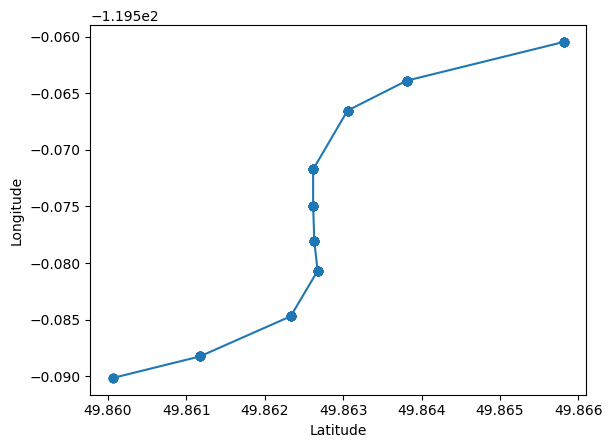

In [76]:
plt.plot(df['position_latitude'], df['position_longitude'], marker='o', linestyle='-')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()